In [10]:
import gudhi as gd
import numpy as np
import matplotlib.pyplot as plt
import pywt
import tensorflow as tf
import pickle
import random as random

In [62]:
print(pickle.format_version)

4.0


In [15]:
import graphviz

In [11]:
!pip install pydot_ng

In [2]:
%load_ext tensorboard

**Create data set with circles in random positions**

In [3]:
def circle(center,radius):
    circ = np.vstack([radius*np.array([np.cos(theta),np.sin(theta)]) + center for theta in np.linspace(0,2*np.pi,30)])
    return circ

#truncate where it's zero, then round to next highest power of 2
def get_trunc_ind(arr):
    for i,_ in enumerate(arr):
        if np.all(arr[i:] == np.zeros(len(arr[i:]))):
            return int(2**(np.ceil(np.log(i)/np.log(2))))
    return len(arr)

def get_len_and_pos(ind,arr):
    #assume ind > 0
    n = np.log(len(arr))/np.log(2)
    wavelength = 2**(n-int((np.log(ind)/np.log(2))))
    pos = (ind-2**(int(np.log(ind)/np.log(2))))*wavelength
    return int(wavelength),int(pos)

def get_output(max_data,all_coeffs):
    coeff,ind = max_data
    if ind == 0:
        return coeff/np.sqrt(len(all_coeffs)),len(all_coeffs),0
    else:
        wl, pos = get_len_and_pos(ind,all_coeffs)
        return coeff/np.sqrt(wl),wl,pos
    
def convert_outputs(x):
    if x == 0:
        return 0
    else:
        return np.log(x)/np.log(2)
    
def pad_and_add(x,y):
    if len(x) >= len(y):
        y = np.pad(y,(0,len(x)-len(y)),'constant',constant_values=0)
    else:
        x = np.pad(x,(0,len(y)-len(x)),'constant',constant_values=0)
    return x + y

def plot_outputs(output1,output2,output3):
    func = np.zeros(1)
    out2 = np.round(output2)
    out3 = np.round(output3)
    for i,coeff in enumerate(output1[:-1]):
        wl = 2**int(np.round(output2[i]))
        
        temppos = int(np.round(output3[i]))
        if temppos == 0:
            pos = 0
        else:
            pos = 2**temppos
        
        to_add = np.hstack([np.zeros(pos),coeff*np.ones(wl//2),(-1)*coeff*np.ones(wl//2)])
        func = pad_and_add(func,to_add)
    func += output1[-1]
    return func
    

In [4]:
try:
    with open('outputs.p','rb') as f:
        outputs = pickle.load(f)
    
    with open('inputs.p','rb') as f:
        inputs = pickle.load(f)
    
except Exception as e:
    inputs = []
    outputs = []
    for i in range(0,2000):
        centers = np.random.random(size=(10,2))
        circle_pts = np.vstack([circle(center,0.5*np.random.random()) for center in centers])
        inputs.append(circle_pts)
        rc = gd.RipsComplex(circle_pts)
        st = rc.create_simplex_tree(max_dimension=2)
        st.persistence()
        temp = st.get_filtration()
        filtrants = sorted(set({x for _,x in temp}))

        betti_data = np.array([st.persistent_betti_numbers(start,end) for start,end in zip(filtrants[:-1],filtrants[1:])])
        trunced_arr = betti_data[:get_trunc_ind(betti_data[:,1]),1]

        coeffs = pywt.wavedec(trunced_arr,wavelet='db1',level=None)
        all_coeffs = np.hstack(coeffs)
        max_inds = np.argpartition(np.abs(all_coeffs),-10)[-10:]
        sorted_max_data = [(x,y) for x,y in sorted(list(zip(all_coeffs[max_inds],max_inds)))]
        output = np.array([get_output(x,all_coeffs) for x in sorted_max_data])
        #output = output/np.max(output,axis=0)
        #output = output.flatten()
        outputs.append(output)

In [5]:
#with open('outputs.p','wb') as f:
#    pickle.dump(outputs,f)
    
#with open('inputs.p','wb') as f:
#    pickle.dump(inputs,f)

In [6]:
arr_inputs = np.array(inputs)

In [7]:
outputs1 = np.array([x[:,0] for x in outputs])
outputs2 = np.array([x[:,1] for x in outputs])
outputs3 = np.array([x[:,2] for x in outputs])

In [8]:
outputs2log = np.array([[convert_outputs(x) for x in arr] for arr in outputs2])
outputs3log = np.array([[convert_outputs(x) for x in arr] for arr in outputs3])

In [70]:
Input = tf.keras.layers.Input((300,2))

Stack1Start = tf.keras.layers.Flatten()(Input)
Stack1Dense = tf.keras.layers.Dense(100, activation='relu',kernel_regularizer = tf.keras.regularizers.l2(0.01))(Stack1Start)
Stack1BN = tf.compat.v2.keras.layers.BatchNormalization()(Stack1Dense)
#Stack1Drop = tf.keras.layers.Dropout(0.2)(Stack1BN)
Stack1Dense2 = tf.keras.layers.Dense(70,activation='relu')(Stack1BN)
Stack1Dense3 = tf.keras.layers.Dense(70,activation='linear',kernel_initializer = tf.keras.initializers.Constant(1/300))(Stack1Start)
Stack1Add = tf.keras.layers.add([Stack1Dense3,Stack1Dense2])
Stack1Out = tf.keras.layers.Dense(10, activation='linear')(Stack1Add)

Stack2Start = tf.keras.layers.Flatten()(Input)
Stack2Dense = tf.keras.layers.Dense(100, activation='relu',kernel_regularizer = tf.keras.regularizers.l2(0.01))(Stack2Start)
Stack2BN = tf.compat.v2.keras.layers.BatchNormalization()(Stack2Dense)
#Stack2Drop = tf.keras.layers.Dropout(0.2)(Stack2BN)
Stack2Dense2 = tf.keras.layers.Dense(70,activation='relu')(Stack2BN)
Stack2Dense3 = tf.keras.layers.Dense(70,activation='linear',kernel_initializer = tf.keras.initializers.Constant(1/300))(Stack2Start)
Stack2Add = tf.keras.layers.add([Stack2Dense3,Stack2Dense2])
Stack2Out = tf.keras.layers.Dense(10, activation='relu')(Stack2Add)

Stack3Start = tf.keras.layers.Flatten()(Input)
Stack3Dense = tf.keras.layers.Dense(100, activation='relu',kernel_regularizer = tf.keras.regularizers.l2(0.01))(Stack3Start)
Stack3BN = tf.compat.v2.keras.layers.BatchNormalization()(Stack3Dense)
#Stack3Drop = tf.keras.layers.Dropout(0.2)(Stack1BN)
Stack3Dense2 = tf.keras.layers.Dense(70,activation='relu')(Stack3BN)
Stack3Dense3 = tf.keras.layers.Dense(70,activation='linear',kernel_initializer = tf.keras.initializers.Constant(1/300))(Stack3Start)
Stack3Add = tf.keras.layers.add([Stack3Dense3,Stack3Dense2])
Stack3Out = tf.keras.layers.Dense(10, activation='relu')(Stack3Add)

model = tf.keras.Model(inputs = Input, outputs = [Stack1Out,Stack2Out,Stack3Out])
#tf.keras.utils.plot_model(model,to_file='model.png')
model.compile(optimizer='adam',
              loss='mean_squared_error',
             )#metrics=['accuracy'])

In [71]:
logdir="logs/fit/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [72]:
model.fit(arr_inputs,[outputs1,outputs2log,outputs3log],epochs=100,callbacks=[tensorboard_callback])

Train on 2000 samples
Epoch 1/100
2000/2000 [==============================] - 2s 1ms/sample - loss: 69.5279 - dense_147_loss: 2.5515 - dense_151_loss: 29.8802 - dense_155_loss: 32.0101
Epoch 2/100
2000/2000 [==============================] - 0s 138us/sample - loss: 30.3283 - dense_147_loss: 1.6021 - dense_151_loss: 1.3253 - dense_155_loss: 23.2839
Epoch 3/100
2000/2000 [==============================] - 0s 130us/sample - loss: 29.0989 - dense_147_loss: 1.5420 - dense_151_loss: 1.1863 - dense_155_loss: 22.8602
Epoch 4/100
2000/2000 [==============================] - 0s 154us/sample - loss: 28.4274 - dense_147_loss: 1.5193 - dense_151_loss: 1.1207 - dense_155_loss: 22.8110
Epoch 5/100
2000/2000 [==============================] - 0s 150us/sample - loss: 27.7865 - dense_147_loss: 1.4894 - dense_151_loss: 1.1201 - dense_155_loss: 22.6645
Epoch 6/100
2000/2000 [==============================] - 0s 136us/sample - loss: 21.5944 - dense_147_loss: 1.4968 - dense_151_loss: 1.0735 - dense_155_los

2000/2000 [==============================] - 0s 137us/sample - loss: 13.5814 - dense_147_loss: 1.3519 - dense_151_loss: 1.0837 - dense_155_loss: 10.8468
Epoch 51/100
2000/2000 [==============================] - 0s 129us/sample - loss: 13.6548 - dense_147_loss: 1.3290 - dense_151_loss: 1.1312 - dense_155_loss: 10.9189
Epoch 52/100
2000/2000 [==============================] - 0s 126us/sample - loss: 13.6663 - dense_147_loss: 1.3493 - dense_151_loss: 1.1053 - dense_155_loss: 10.9149
Epoch 53/100
2000/2000 [==============================] - 0s 127us/sample - loss: 13.4321 - dense_147_loss: 1.3539 - dense_151_loss: 1.0393 - dense_155_loss: 10.7568
Epoch 54/100
2000/2000 [==============================] - 0s 130us/sample - loss: 13.4675 - dense_147_loss: 1.3445 - dense_151_loss: 1.0831 - dense_155_loss: 10.7659
Epoch 55/100
2000/2000 [==============================] - 0s 126us/sample - loss: 13.4374 - dense_147_loss: 1.3345 - dense_151_loss: 1.0603 - dense_155_loss: 10.7612
Epoch 56/100
2000

2000/2000 [==============================] - 0s 128us/sample - loss: 12.6826 - dense_147_loss: 1.2967 - dense_151_loss: 1.1480 - dense_155_loss: 9.9241
Epoch 99/100
2000/2000 [==============================] - 0s 123us/sample - loss: 12.6650 - dense_147_loss: 1.3006 - dense_151_loss: 1.0521 - dense_155_loss: 9.9765
Epoch 100/100
2000/2000 [==============================] - 0s 124us/sample - loss: 12.7178 - dense_147_loss: 1.2820 - dense_151_loss: 1.0593 - dense_155_loss: 10.0107


In [73]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 90663), started 2 days, 22:05:40 ago. (Use '!kill 90663' to kill it.)

In [74]:
model.predict(arr_inputs[0:1,:,:])

[array([[-5.0894012, -4.900518 , -2.1977096,  0.8615897,  1.9007092,
          2.1433735,  2.4955156,  3.0393615,  3.2884798,  3.8734627]],
       dtype=float32),
 array([[11.440623, 10.779807,  9.881778, 11.98267 , 10.865874, 11.425975,
         12.265245, 13.498289, 13.794109, 14.161985]], dtype=float32),
 array([[ 0.       ,  0.       ,  7.3241363, 11.178413 , 10.500403 ,
          8.155048 ,  7.9299374,  0.       ,  0.       ,  0.       ]],
       dtype=float32)]

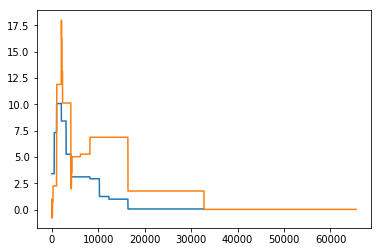

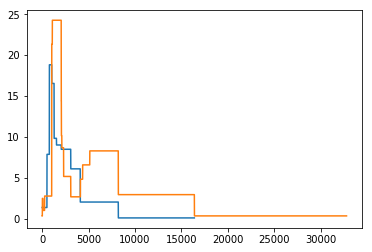

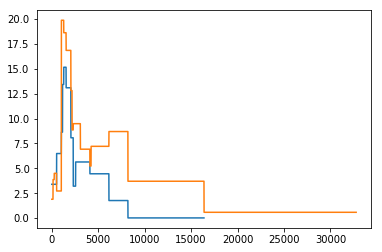

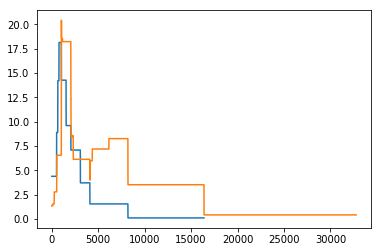

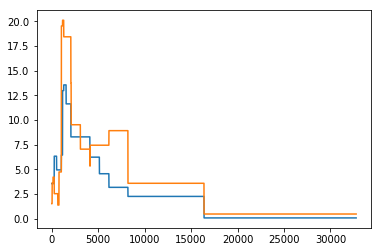

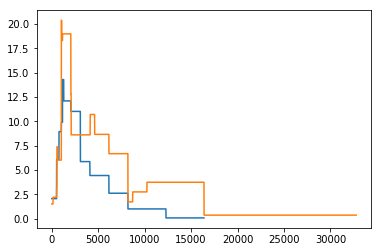

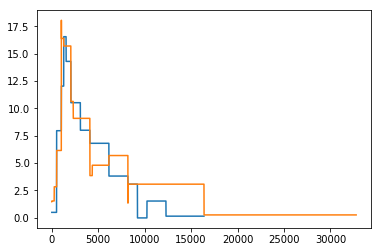

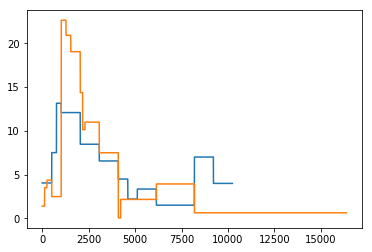

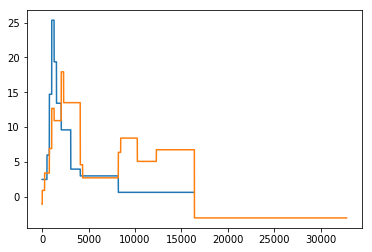

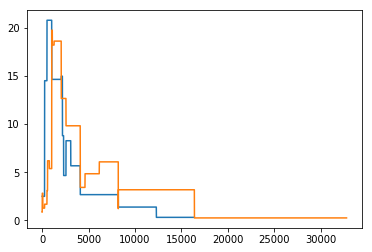

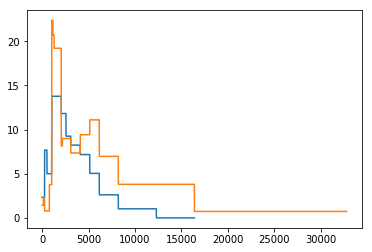

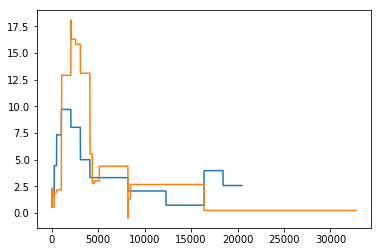

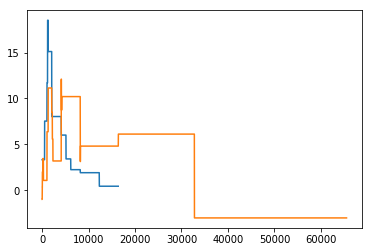

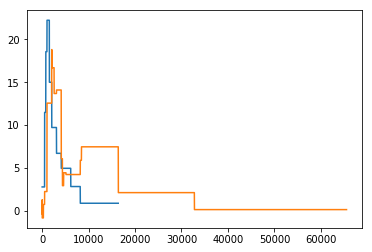

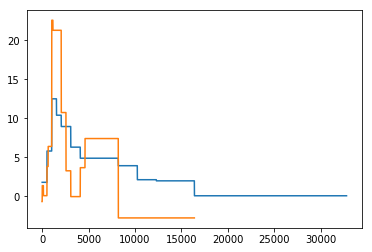

In [75]:
for i in range(30,45):
    plt.figure()
    plt.plot(plot_outputs(outputs1[i],outputs2log[i],outputs3log[i]))
    sample_input = arr_inputs[i:i+1][0]
    random.shuffle(sample_input)
    sample_input = np.expand_dims(sample_input,0)
    plt.plot(plot_outputs(*[x[0] for x in model.predict(sample_input)]))

In [42]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 300, 2)]     0                                            
__________________________________________________________________________________________________
flatten_21 (Flatten)            (None, 600)          0           input_8[0][0]                    
__________________________________________________________________________________________________
flatten_22 (Flatten)            (None, 600)          0           input_8[0][0]                    
__________________________________________________________________________________________________
dense_84 (Dense)                (None, 100)          60100       flatten_21[0][0]                 
____________________________________________________________________________________________

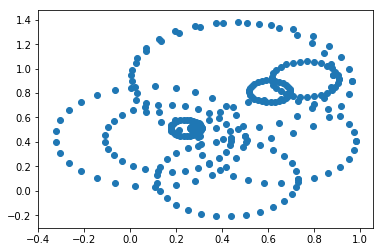

In [44]:
plt.scatter(inputs[16][:,0],inputs[16][:,1])